In [3]:
# Import需要的套件
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import time
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [4]:
# Import需要的套件
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import time
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
# 定义标签和类别字典以及常量 N
label_dict = {"automobile": 0, "airplane": 1, "frog": 2}
class_dict = {0: "automobile", 1: "airplane", 2: "frog"}
N = 3  # 总共三个类别

class MyDataset(Dataset):
    def __init__(self, _data_dir, _transform, _loader):
        # 获取标签文件夹列表
        self.labels = [_label for _label in os.listdir(_data_dir)]
        _file_path_label_list = [(os.path.join(_data_dir, _label, _img_fn), _label)
                                 for _label in os.listdir(_data_dir)
                                 for _img_fn in os.listdir(os.path.join(_data_dir, _label))
                                 if not os.path.isdir(os.path.join(_data_dir, _label, _img_fn))]

        self.data = [(_loader(_fp), label_dict[_label]) for _fp, _label in _file_path_label_list]
        self.transform = _transform
#         self.labels = [label for label in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, label))]
        
#         # 获取图像路径和标签的配对列表
#         self.data = []
#         for label in self.labels:
#             label_path = os.path.join(data_dir, label)
#             for img_fn in os.listdir(label_path):
#                 img_path = os.path.join(label_path, img_fn)
#                 if not os.path.isdir(img_path):
#                     self.data.append((img_path, label_dict[label]))

        # self.transform = transform

    def __getitem__(self, item):
        _img, _label = self.data[item]
        _img = self.transform(_img)
        return _img, _label
        # img_path, label = self.data[index]
        # img = Image.open(img_path).convert('RGB')
        # if self.transform:
        #     img = self.transform(img)
        # return img, label

    def __len__(self):
        return len(self.data)

def load_data():
    print('data processing...')
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # normalization
    ])
    data_dir = "data/training_data/"
    train_dataset = MyDataset(data_dir, transform, _loader=lambda _path: Image.open(_path).convert('RGB'))
    test_dataset = MyDataset(data_dir, transform, _loader=lambda _path: Image.open(_path).convert('RGB'))

    train_size = int(len(train_dataset) * 0.8)
    validate_size = len(train_dataset) - train_size
    train, val = torch.utils.data.random_split(train_dataset, [train_size, validate_size])

    train_data_loader = DataLoader(dataset=train, batch_size=50, shuffle=True, num_workers=0)
    val_data_loader = DataLoader(dataset=val, batch_size=50, shuffle=True, num_workers=0)
    test_data_loader = DataLoader(dataset=test_dataset, batch_size=50, shuffle=False, num_workers=0)

    return train_data_loader, val_data_loader, test_data_loader

In [6]:
import copy
import os
import random

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

# from classify.data_process import load_data, N, label_dict, class_dict
import torch.nn.functional as F

from classify.decorator import metric_time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def setup_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


setup_seed(20)


class cnn(nn.Module):
    def __init__(self, in_channels=3):
        super(cnn, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=16,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.fc1 = nn.Linear(3 * 3 * 64, 64)
        self.fc2 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.out = nn.Linear(10, N)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.out(x))
        x = F.log_softmax(x, dim=1)
        return x


def get_val_loss(model, Val):
    model.eval()
    criterion = nn.CrossEntropyLoss().to(device)
    val_loss = []
    for (data, target) in Val:
        data, target = data.to(device), target.long().to(device)
        output = model(data)
        loss = criterion(output, target)
        val_loss.append(loss.cpu().item())

    return np.mean(val_loss)


@metric_time
def train():
    train_data_loader, val_data_loader, _ = load_data()
    print('train...')
    epoch_num = 30
    best_model = None
    min_epochs = 5
    min_val_loss = 5
    model = cnn().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0008)
    criterion = nn.CrossEntropyLoss().to(device)
    for epoch in tqdm(range(epoch_num), ascii=True):
        train_loss = []
        for batch_idx, (data, target) in enumerate(train_data_loader):
            data, target = data.to(device), target.long().to(device)
            model.train()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.cpu().item())
        # validation
        val_loss = get_val_loss(model, val_data_loader)
        if epoch + 1 > min_epochs and val_loss < min_val_loss:
            min_val_loss = val_loss
            best_model = copy.deepcopy(model)

        tqdm.write('Epoch {:03d} train_loss {:.5f} val_loss {:.5f}'.format(epoch, np.mean(train_loss), val_loss))

    torch.save(best_model.state_dict(), "model/cnn.pkl")


@metric_time
def test():
    _, _, test_dataset = load_data()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = cnn().to(device)
    model.load_state_dict(torch.load("model/cnn.pkl"), False)
    total = 0
    current = 0
    model.eval()
    for (data, target) in test_dataset:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        predicted = torch.max(outputs.data, 1)[1].data
        total += target.size(0)
        current += (predicted == target).sum()

    print('Accuracy:%d%%' % (100 * current / total))

# 训练模型

In [7]:
train()

data processing...
train...


  3%|3         | 1/30 [00:01<00:48,  1.67s/it]

Epoch 000 train_loss 1.08649 val_loss 1.09802


  7%|6         | 2/30 [00:03<00:46,  1.67s/it]

Epoch 001 train_loss 1.04207 val_loss 1.08652


 10%|#         | 3/30 [00:04<00:44,  1.64s/it]

Epoch 002 train_loss 1.00149 val_loss 1.06026


 13%|#3        | 4/30 [00:06<00:42,  1.63s/it]

Epoch 003 train_loss 0.95533 val_loss 1.00820


 17%|#6        | 5/30 [00:08<00:40,  1.63s/it]

Epoch 004 train_loss 0.92095 val_loss 0.95487


 20%|##        | 6/30 [00:09<00:38,  1.59s/it]

Epoch 005 train_loss 0.88718 val_loss 0.89527


 23%|##3       | 7/30 [00:11<00:36,  1.58s/it]

Epoch 006 train_loss 0.87367 val_loss 0.89391


 27%|##6       | 8/30 [00:12<00:34,  1.57s/it]

Epoch 007 train_loss 0.83389 val_loss 0.85359


 30%|###       | 9/30 [00:14<00:33,  1.58s/it]

Epoch 008 train_loss 0.80426 val_loss 0.79433


 33%|###3      | 10/30 [00:16<00:31,  1.58s/it]

Epoch 009 train_loss 0.78704 val_loss 0.83964


 37%|###6      | 11/30 [00:17<00:30,  1.59s/it]

Epoch 010 train_loss 0.77802 val_loss 0.77653


 40%|####      | 12/30 [00:19<00:29,  1.62s/it]

Epoch 011 train_loss 0.73820 val_loss 0.74557


 43%|####3     | 13/30 [00:20<00:27,  1.62s/it]

Epoch 012 train_loss 0.73715 val_loss 0.71680


 47%|####6     | 14/30 [00:22<00:25,  1.61s/it]

Epoch 013 train_loss 0.72496 val_loss 0.72251


 50%|#####     | 15/30 [00:24<00:24,  1.60s/it]

Epoch 014 train_loss 0.70935 val_loss 0.73235


 53%|#####3    | 16/30 [00:25<00:22,  1.60s/it]

Epoch 015 train_loss 0.70679 val_loss 0.71797


 57%|#####6    | 17/30 [00:27<00:20,  1.61s/it]

Epoch 016 train_loss 0.70958 val_loss 0.79486


 60%|######    | 18/30 [00:28<00:19,  1.61s/it]

Epoch 017 train_loss 0.68348 val_loss 0.70528


 63%|######3   | 19/30 [00:30<00:17,  1.61s/it]

Epoch 018 train_loss 0.69646 val_loss 0.69554


 67%|######6   | 20/30 [00:32<00:16,  1.62s/it]

Epoch 019 train_loss 0.68789 val_loss 0.72207


 70%|#######   | 21/30 [00:33<00:14,  1.61s/it]

Epoch 020 train_loss 0.67558 val_loss 0.69623


 73%|#######3  | 22/30 [00:35<00:12,  1.62s/it]

Epoch 021 train_loss 0.68496 val_loss 0.71201


 77%|#######6  | 23/30 [00:36<00:11,  1.59s/it]

Epoch 022 train_loss 0.67031 val_loss 0.69586


 80%|########  | 24/30 [00:38<00:09,  1.58s/it]

Epoch 023 train_loss 0.66027 val_loss 0.68786


 83%|########3 | 25/30 [00:40<00:07,  1.59s/it]

Epoch 024 train_loss 0.67439 val_loss 0.70738


 87%|########6 | 26/30 [00:41<00:06,  1.60s/it]

Epoch 025 train_loss 0.64709 val_loss 0.66755


 90%|######### | 27/30 [00:43<00:04,  1.60s/it]

Epoch 026 train_loss 0.64382 val_loss 0.69572


 93%|#########3| 28/30 [00:44<00:03,  1.59s/it]

Epoch 027 train_loss 0.64797 val_loss 0.74035


 97%|#########6| 29/30 [00:46<00:01,  1.60s/it]

Epoch 028 train_loss 0.64784 val_loss 0.69221


100%|##########| 30/30 [00:48<00:00,  1.60s/it]
2024-11-29 10:17:16.877 | DEBUG    | classify.decorator:wrapper:13 - train运行时间: 48.557636976242065 s


Epoch 029 train_loss 0.65993 val_loss 0.66561


# 测试模型预测准确率

In [8]:
test()

data processing...


C:\Users\admin\AppData\Local\Temp/ipykernel_13228/934605258.py:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model/cnn.pkl"), False)
2

Accuracy:91%


In [9]:
from PIL import Image
from matplotlib import pyplot as plt
from torchvision import transforms

In [13]:
model = cnn().to(device)
model.load_state_dict(torch.load("model/cnn.pkl"), False)
model.eval()

_img_path = "data/testing_data/airplane/airplane-00029.jpg"

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # normalization
])
img = Image.open(_img_path).convert('RGB')
# 模拟批样本
img_transform = transform(img).unsqueeze(0)

output = model(img_transform)
pred = class_dict[torch.max(output.data, 1)[1].data.item()]
print(pred)

airplane


C:\Users\admin\AppData\Local\Temp/ipykernel_13228/3990064704.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model/cnn.pkl"), False)


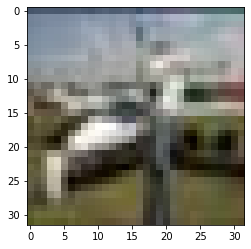

In [14]:
plt.imshow(img, cmap='gray')
plt.show()